In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

train = pd.read_csv("/content/nba_games_train.csv") # train 데이터셋
test = pd.read_csv("/content/nba_games_test.csv") # test 데이터셋

print(train.shape, test.shape)

from google.colab import drive
drive.mount('/content/drive')

# 'max'로 끝나는 컬럼 선택

max_columns_train = [col for col in train if (col.endswith('_max') or col.endswith('_max_opp')) and col!='mp_max_opp.1']
max_columns_test = [col for col in test if (col.endswith('_max') or col.endswith('_max_opp')) and col!='mp_max_opp.1']

def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


import re

# '%'를 포함하는 컬럼들을 모으는 정규표현식
pattern = re.compile('.*%.*')

# max_columns 중에서 '%'를 포함하는 컬럼들을 선택
minmax_columns_train = [col for col in max_columns_train if pattern.match(col)]
robust_columns_train = train[max_columns_train].drop(columns=minmax_columns_train).columns.tolist()
minmax_columns_test = [col for col in max_columns_test if pattern.match(col)]
robust_columns_test = test[max_columns_test].drop(columns=minmax_columns_test).columns.tolist()

additional_columns = ['ftr', '3par']

minmax_columns_train.extend(additional_columns) # max_columns 중에서 '%','ftr', '3par'를 포함하는 컬럼들을 선택
minmax_columns_test.extend(additional_columns) # max_columns 중에서 '%','ftr', '3par'를 포함하는 컬럼들을 선택

other_columns_train = train.drop(columns=max_columns_train).columns.tolist()
other_columns_test = test.drop(columns=max_columns_test).columns.tolist()

# 중복을 제거하여 'ftr', '3par'을 포함하지 않는 컬럼들 선택
standard_columns_train = [col for col in other_columns_train if col not in additional_columns]
standard_columns_test = [col for col in other_columns_test if col not in additional_columns]

train2 = train.copy()
train3 = train.copy()
train4 = train.copy()
test2 = test.copy()
test3 = test.copy()
test4 = test.copy()

train2 = train[standard_columns_train]
train3 = train[minmax_columns_train]
train4 = train[robust_columns_train]
test2 = test[standard_columns_test]
test3 = test[minmax_columns_test]
test4 = test[robust_columns_test]

# 이상치 제거된 데이터프레임 생성
train3 = remove_outliers(train3, minmax_columns_train)
train4 = remove_outliers(train4, robust_columns_train)
test3 = remove_outliers(test3, minmax_columns_test)
test4 = remove_outliers(test4, robust_columns_test)

train5 = train2[standard_columns_train]
string_columns_train = train5.select_dtypes(include=['object']).columns
print(string_columns_train)

test5 = test2[standard_columns_test]
string_columns_test = test5.select_dtypes(include=['object']).columns
print(string_columns_test)

# 1. date 컬럼을 라벨 인코딩했는데, train에 대해 fit_transform으로 학습한 인코더 객체가 test에 대해
# 학습한 방식을 transform하여 적용할 경우 날짜가 상이하므로 오류 발생하여 실행 x
# -> gpt가 제시한 방법 중 train,test 병합해서 통째로 인코딩 후 분리 : 이건 애초에 정답 유출 문제 + new data 예측 불가 문제
# -> 기준 날짜로부터 일수 변환하는 방법으로 대체(이 방식을 채택함)
# -> (수정)이렇게 해놓고 나니 인코딩할 필요가 없어져서 문제가 해결됨
train5['date'] = pd.to_datetime(train5['date'])
test5['date'] = pd.to_datetime(test5['date'])
# object type이므로 날짜 형식으로 변경

print(train5['date'].dtype, test5['date'].dtype)

print("First date in 'date' column of train:", train5['date'].min())
print("First date in 'date' column of test:", test5['date'].min())

# test 데이터셋의 가장 이른 날짜인 2015-10-27을 시작의 기준으로 하자.
base_date = pd.to_datetime('2015-12-09')

# 날짜를 일수로 변환
train5['days_from_base'] = (train5['date'] - base_date).dt.days
test5['days_from_base'] = (test5['date'] - base_date).dt.days

# 날짜 열 제거
train5 = train5.drop('date', axis=1)
test5 = test5.drop('date', axis=1)

# # Object 타입 변수 인코딩 - (1) 날짜 : 라벨 인코딩

# # date 열을 Label Encoding 적용
# label_encoder = LabelEncoder() # 인코더 객체가 train으로 학습&변환, test는 train에서 학습한 것 기반으로 변환(Don't fit_transform for test dataset)

# train5['date_encoded'] = label_encoder.fit_transform(train5['days_from_base'])
# train5 = train5.drop('days_from_base', axis=1)


# test5['date_encoded'] = label_encoder.transform(test5['days_from_base'])
# test5 = test5.drop('days_from_base', axis=1)

# # 주의 사항(ChatGPT)
# #테스트 데이터셋에 훈련 데이터셋에 없는 새로운 카테고리가 있는 경우, LabelEncoder는 해당 값을 처리하지 못하고 에러를 발생시킵니다. 이를 처리하려면 새로운 카테고리를 미리 예측하여 적절한 조치를 취해야 합니다.

train5 = train5.rename(columns={'days_from_base': 'date_gap'})
test5 = test5.rename(columns={'days_from_base': 'date_gap'})

# 2번째 고민 : 타깃 인코딩은 정답 레이블을 포함하기에 데이터 누수가 발생하게 됨. 이를 방지하고자
# k-fold로 교차 진행을 하는데, train은 어느 정도 예방이 된다고 하더라도 test dataset에서의 정답 컬럼을
# 건드는 것은 미친 짓임.
# -> train의 인코딩 결과를 test에 적용

# 훈련 데이터셋에 대한 타겟 인코딩
kf_train = KFold(n_splits=5, shuffle=True, random_state=42)
train5['team_encoded'] = 0
train5['team_opp_encoded'] = 0

for train_idx, val_idx in kf_train.split(train5):
    train_data = train5.iloc[train_idx]

    # 각 팀별 'won' 컬럼의 평균 계산 (훈련 데이터에서만)
    team_target_means = train_data.groupby('team')['won'].mean()

    # 'team'과 'team_opp' 컬럼을 인코딩된 값으로 대체
    train5.loc[val_idx, 'team_encoded'] = train5.iloc[val_idx]['team'].map(team_target_means)
    train5.loc[val_idx, 'team_opp_encoded'] = train5.iloc[val_idx]['team_opp'].map(team_target_means)

# 노이즈 추가
smoothing = 0.1
train5['team_encoded'] = train5['team_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(train5))
train5['team_opp_encoded'] = train5['team_opp_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(train5))

# 테스트 데이터셋에 대한 타겟 인코딩
kf_test = KFold(n_splits=5, shuffle=True, random_state=42)
test5['team_encoded'] = 0
test5['team_opp_encoded'] = 0

for train_idx, _ in kf_test.split(train5):  # 테스트 데이터셋에 대한 교차 검증은 훈련 데이터셋에 대해서만 수행
    train_data = train5.iloc[train_idx]

    # 각 팀별 'won' 컬럼의 평균 계산 (훈련 데이터에서만)
    team_target_means = train_data.groupby('team')['won'].mean()

    # 'team'과 'team_opp' 컬럼을 인코딩된 값으로 대체
    test5['team_encoded'] += test5['team'].map(team_target_means)
    test5['team_opp_encoded'] += test5['team_opp'].map(team_target_means)

# 교차 검증 인코딩 값의 평균 계산
test5['team_encoded'] /= kf_test.n_splits
test5['team_opp_encoded'] /= kf_test.n_splits

# 노이즈 추가
smoothing = 0.1
test5['team_encoded'] = test5['team_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(test5))
test5['team_opp_encoded'] = test5['team_opp_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(test5))

# 결과 출력
train5 = train5.drop(['team', 'team_opp'], axis=1)
print(train5.shape)

test5 = test5.drop(['team', 'team_opp'], axis=1)
print(test5.shape)

from sklearn.preprocessing import RobustScaler, MinMaxScaler
# RobustScaler 객체 생성
scaler = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()
# max_columns에 대해 RobustScaler 적용
standard_scaled_train5 = scaler.fit_transform(train5)
minmax_scaled_train3 = scaler2.fit_transform(train3)
robust_scaled_train4 = scaler3.fit_transform(train4)

standard_scaled_test5 = scaler.transform(test5)
minmax_scaled_test3 = scaler2.transform(test3)
robust_scaled_test4 = scaler3.transform(test4)

standard_scaled_train5 = pd.DataFrame(standard_scaled_train5, columns=train5.columns)
minmax_scaled_train3 = pd.DataFrame(minmax_scaled_train3, columns=train3.columns)
robust_scaled_train4 = pd.DataFrame(robust_scaled_train4, columns=train4.columns)

standard_scaled_test5 = pd.DataFrame(standard_scaled_test5, columns=test5.columns)
minmax_scaled_test3 = pd.DataFrame(minmax_scaled_test3, columns=test3.columns)
robust_scaled_test4 = pd.DataFrame(robust_scaled_test4, columns=test4.columns)

# 진짜 중요한거
standard_scaled_train5['won'] = train5['won']
standard_scaled_test5['won'] = test5['won']

# 정답 컬럼, 특히 test 데이터셋의 label은 결측치 처리와 인코딩 정도를 제외하곤 절대 건드리지 말 것

# 각기 다른 스케일러로 조정된 3개 df 합치기
train_combined = pd.concat([robust_scaled_train4, minmax_scaled_train3, standard_scaled_train5], axis=1)
test_combined = pd.concat([robust_scaled_test4, minmax_scaled_test3, standard_scaled_test5], axis=1)

# null 값이 포함된 행을 삭제
train_cleaned = train_combined.dropna()
test_cleaned = test_combined.dropna()
print(train_cleaned.shape, test_cleaned.shape)

# 승패 비율 계산
print(train_cleaned['won'].value_counts(normalize=True))
print(test_cleaned['won'].value_counts(normalize=True))

(17772, 137) (2308, 137)
Mounted at /content/drive
Index(['team', 'team_opp', 'date'], dtype='object')
Index(['team', 'team_opp', 'date'], dtype='object')
datetime64[ns] datetime64[ns]
First date in 'date' column of train: 2015-10-27 00:00:00
First date in 'date' column of test: 2022-10-18 00:00:00
(17772, 71)
(2308, 71)
(14283, 137) (1843, 137)
won
False    0.500035
True     0.499965
Name: proportion, dtype: float64
won
True     0.500271
False    0.499729
Name: proportion, dtype: float64


### 다중공선성 해결
* 모델의 성능을 기반으로 가장 중요하지 않은 특성들을 재귀적으로 제거하여 최적의 특성 수를 찾는 특성 선택 방법

* RandomForestClassifier를 추정기로 사용

* RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

  estimator: 특성 중요도를 평가하기 위한 모델.

  step: 파라미터의 각 반복에서 제거할 특성의 수. (반복의 총 횟수는 모델이 최적의 특성 집합을 찾을 때까지 수행되는 반복의 수에 따라 달라짐)
  step 값이 1이기 때문에 최소 137번 반복해서 서치

  cv: 교차 검증을 위한 분할 전략.

  scoring: 모델 성능을 평가할 지표.

* 모델 반복 종료 조건

  더 이상 제거할 특성이 없거나,

  min_features_to_select에 지정된 최소 특성 수에 도달하거나,

  제거 후 남은 특성들로 최적의 성능이 확인될 때까지 반복


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Features와 target 분리
X_train = train_cleaned.drop('won', axis=1)
y_train = train_cleaned['won']

X_test = test_cleaned.drop('won', axis=1)
y_test = test_cleaned['won']

# 모델 정의
model = RandomForestClassifier(n_estimators=100, random_state=42)

# RFECV 정의
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# RFECV를 훈련 데이터에 맞추기
rfecv.fit(X_train, y_train)

# 선택된 특성들로 훈련 및 테스트 데이터 변환
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# 최적의 특성 수 출력
print(f'Optimal number of features: {rfecv.n_features_}')

# 선택된 특성들 출력
selected_features = X_train.columns[rfecv.support_]
print(f'Selected features: {selected_features}')

# 선택된 특성들로 모델 훈련
model.fit(X_train_selected, y_train)

# 모델 평가
train_accuracy = model.score(X_train_selected, y_train)
test_accuracy = model.score(X_test_selected, y_test)

print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')


Optimal number of features: 5
Selected features: Index(['ortg', 'drtg', 'pts_opp', 'ortg_opp', 'drtg_opp'], dtype='object')
Training accuracy: 1.0
Test accuracy: 0.9994574064026045


step 값으로 default인 1을 사용 -> 5개의 피쳐만 남음. : ortg, drtg ==> 훈련데이터 및 테스트 데이터 성능도 좋음.

추가로, 최소 피쳐 선택의 개수를 n개로 지정해보기로 함.

* RFECV를 통해 전체 특성의 중요도 순위를 추출
* RFECV는 각 반복 단계에서 특성을 제거하면서 모델의 성능을 평가하기 때문에, 최종적으로 남은 특성들 뿐만 아니라, 제거된 특성들의 순위도 제공

Optimal number of features: 5
Selected features: Index(['ortg', 'drtg', 'pts_opp', 'ortg_opp', 'drtg_opp'], dtype='object')
Feature ranking:
drtg_opp        1
ortg_opp        1
drtg            1
ortg            1
pts_opp         1
             ... 
pf_max        128
home_opp      129
stl_max       130
home          131
pf_max_opp    132
Length: 136, dtype: int64


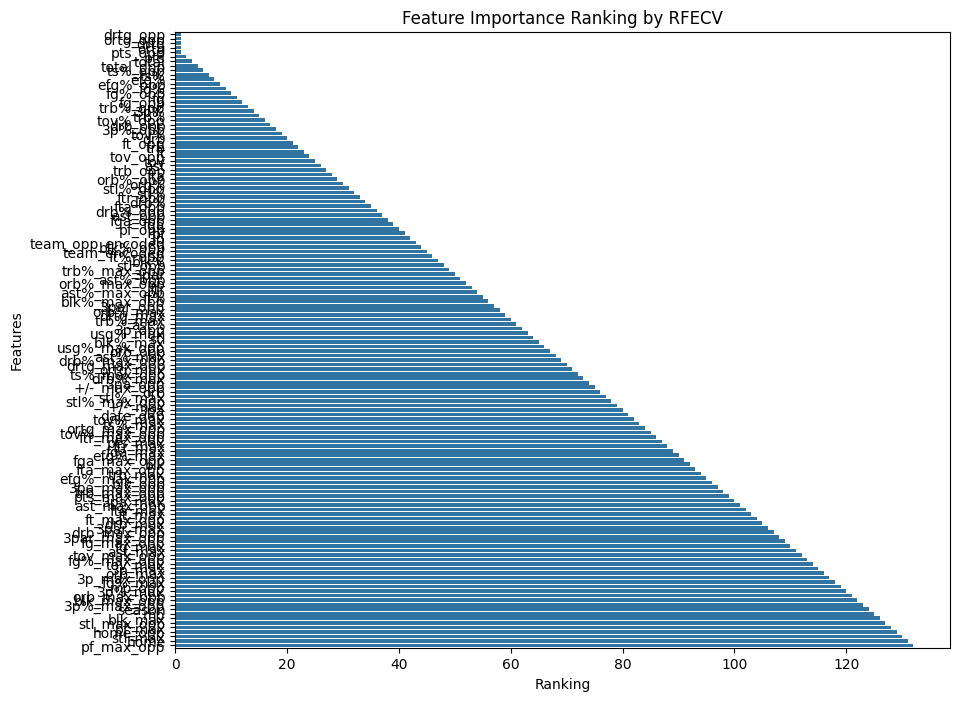

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

# 데이터 로드 및 분리
X = train_cleaned.drop('won', axis=1)
y = train_cleaned['won']

# 모델 정의
model = RandomForestClassifier(n_estimators=100, random_state=42)

# RFECV 정의
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# RFECV를 훈련 데이터에 맞추기
rfecv.fit(X, y)

# 최적의 특성 수 출력
print(f'Optimal number of features: {rfecv.n_features_}')

# 선택된 특성들 출력
selected_features = X.columns[rfecv.support_]
print(f'Selected features: {selected_features}')

# 전체 특성의 중요도 순위 출력
feature_ranking = pd.Series(rfecv.ranking_, index=X.columns).sort_values()
print(f'Feature ranking:\n{feature_ranking}')

# 중요도 순위 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_ranking.values, y=feature_ranking.index)
plt.title('Feature Importance Ranking by RFECV')
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.show()


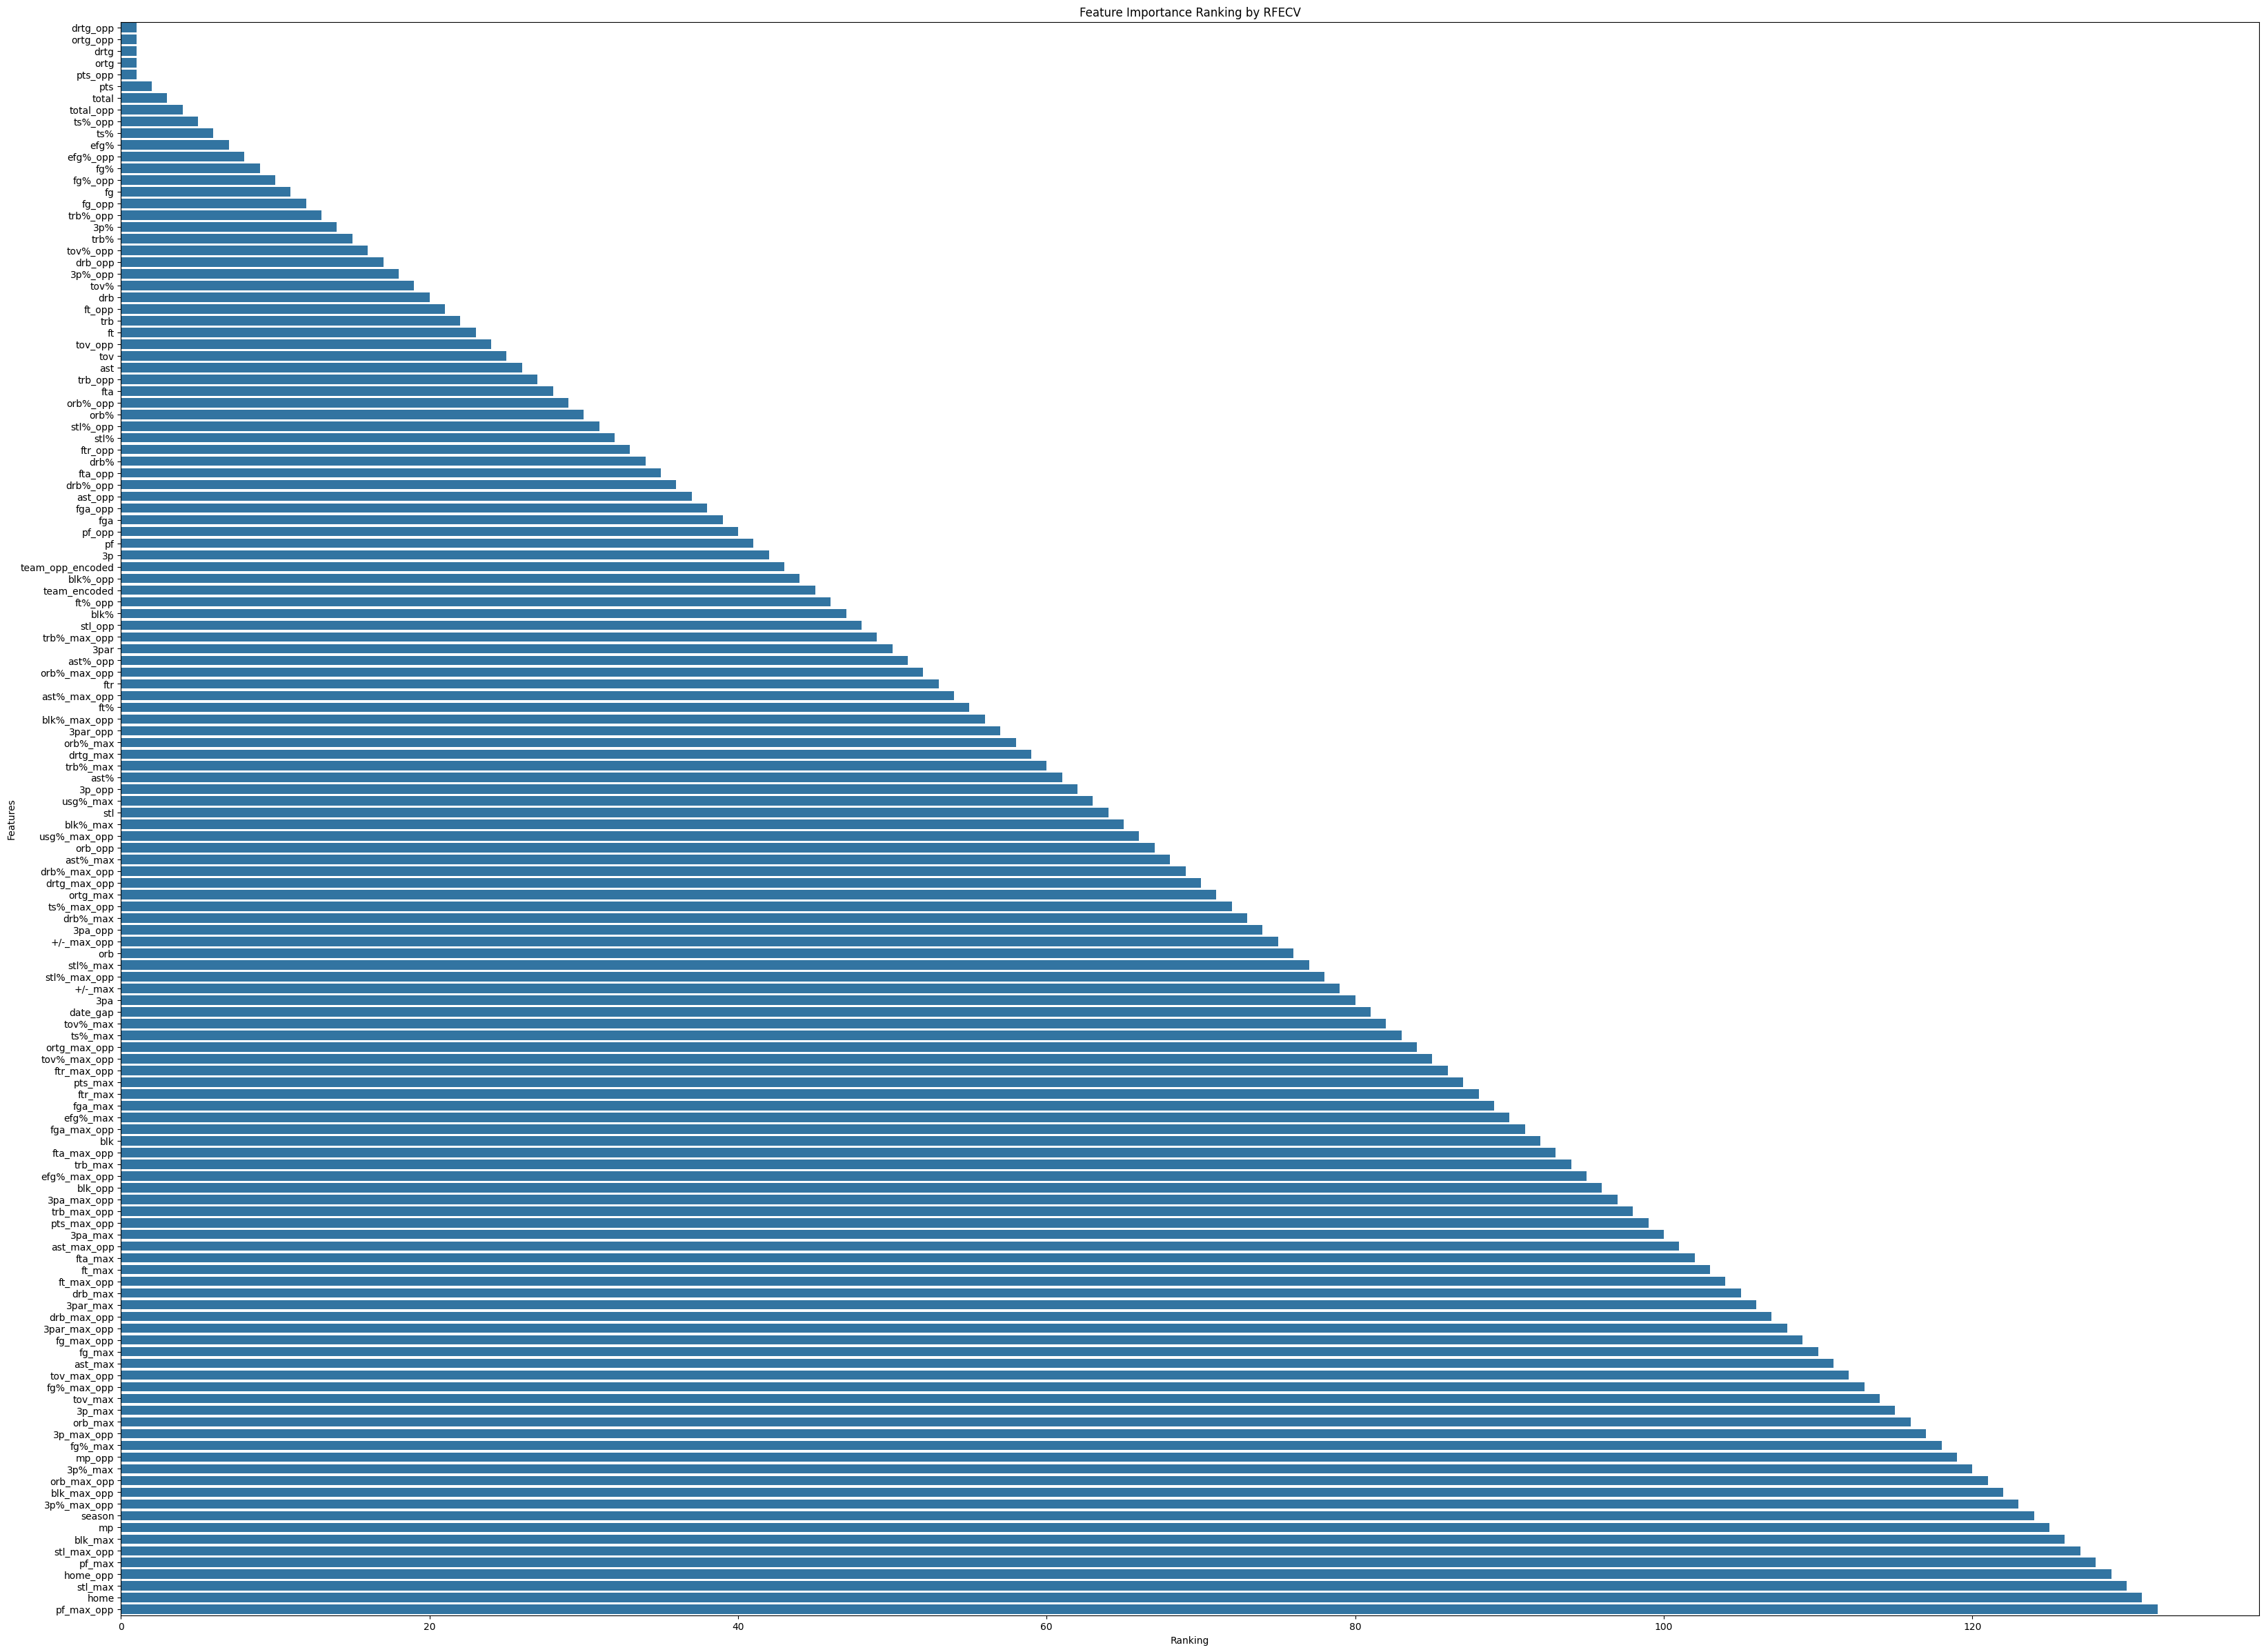

In [ ]:
plt.figure(figsize=(40, 30))
sns.barplot(x=feature_ranking.values, y=feature_ranking.index)
plt.title('Feature Importance Ranking by RFECV')
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Features와 target 분리
X_train = train_cleaned.drop('won', axis=1)
y_train = train_cleaned['won']

X_test = test_cleaned.drop('won', axis=1)
y_test = test_cleaned['won']

# 모델 정의
model = RandomForestClassifier(n_estimators=100, random_state=42)

# RFECV 정의 (최소 10개의 특성을 선택하도록 설정)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy', min_features_to_select=10)

# RFECV를 훈련 데이터에 맞추기
rfecv.fit(X_train, y_train)

# 선택된 특성들로 훈련 및 테스트 데이터 변환
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# 최적의 특성 수 출력
print(f'Optimal number of features: {rfecv.n_features_}')

# 선택된 특성들 출력
selected_features = X_train.columns[rfecv.support_]
print(f'Selected features: {selected_features}')

# # 선택된 주요 피쳐로 데이터프레임 생성
# X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
# X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)

# # 히트맵으로 상관관계 확인
# plt.figure(figsize=(12, 10))
# sns.heatmap(X_train_selected_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Heatmap of Selected Features')
# plt.show()

# 선택된 피쳐로 모델 훈련 및 평가
model.fit(X_train_selected_df, y_train)
train_accuracy = model.score(X_train_selected_df, y_train)
test_accuracy = model.score(X_test_selected_df, y_test)

print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')


Optimal number of features: 10
Selected features: Index(['pts', 'ts%', 'ortg', 'drtg', 'total', 'pts_opp', 'ts%_opp', 'ortg_opp',
       'drtg_opp', 'total_opp'],
      dtype='object')


NameError: name 'X_train_selected_df' is not defined